# 🫒 Classification des Maladies des Feuilles d'Olivier
## Algorithme : Support Vector Machine (SVM)
---
**Dataset** : Olive Leaf Disease (3 classes : Healthy, Aculus Olearius, Peacock Spot)  
**Méthode** : Extraction de features → Normalisation → SVM (kernel RBF)  
**Objectif** : Classifier automatiquement les maladies à partir d'images

---
## 📦 Section 1 — Importation des librairies

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

# Machine Learning
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import (classification_report, confusion_matrix,
                              accuracy_score, ConfusionMatrixDisplay)
from sklearn.pipeline import Pipeline
import joblib

# Création des dossiers de sortie
os.makedirs("reports", exist_ok=True)
os.makedirs("models",  exist_ok=True)

print("✅ Toutes les librairies importées avec succès")

✅ Toutes les librairies importées avec succès


---
## 📂 Section 2 — Chargement du dataset

In [2]:
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# PARAMÈTRES
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
DATASET_PATH = r"C:\Users\User\Downloads\Olive\Olive\dataset"
TEST_PATH    = r"C:\Users\User\Downloads\Olive\Olive\test"
IMG_SIZE     = (64, 64)

# Détection des classes
classes = sorted([d for d in os.listdir(DATASET_PATH)
                  if os.path.isdir(os.path.join(DATASET_PATH, d))])

print(f"Classes détectées : {classes}")
print(f"Nombre de classes : {len(classes)}")

# Comptage des images
print("\nDistribution :")
total = 0
for cls in classes:
    n = len([f for f in os.listdir(os.path.join(DATASET_PATH, cls))
             if f.lower().endswith((".jpg",".jpeg",".png"))])
    total += n
    print(f"   {cls} : {n} images")

print(f"   Total : {total} images")

Classes détectées : ['Healthy', 'aculus_olearius', 'olive_peacock_spot']
Nombre de classes : 3

Distribution :
   Healthy : 830 images
   aculus_olearius : 690 images
   olive_peacock_spot : 1200 images
   Total : 2720 images


---
## 🔬 Section 3 — Extraction des features

Pour le SVM, on ne peut pas donner directement les images brutes.  
On extrait un **vecteur de features** par image combinant :
- **Pixels aplatis** (64×64×3 = 12 288 valeurs normalisées)
- **Histogramme RGB** (256 bins × 3 canaux = 768 valeurs)

→ Vecteur final : **13 056 features** par image

In [3]:
def extract_features(img_path, size=(64, 64)):
    """
    Extrait un vecteur de features à partir d'une image :
    - Pixels aplatis (normalisés 0-1)
    - Histogramme RGB (256 bins par canal)
    """
    img = Image.open(img_path).convert("RGB").resize(size)
    arr = np.array(img, dtype=np.float32) / 255.0

    # Feature 1 : pixels aplatis
    pixels = arr.flatten()

    # Feature 2 : histogramme RGB
    hist_r, _ = np.histogram(arr[:,:,0], bins=256, range=(0,1))
    hist_g, _ = np.histogram(arr[:,:,1], bins=256, range=(0,1))
    hist_b, _ = np.histogram(arr[:,:,2], bins=256, range=(0,1))
    histogram  = np.concatenate([hist_r, hist_g, hist_b]).astype(np.float32)
    histogram /= (histogram.sum() + 1e-8)   # normaliser

    return np.concatenate([pixels, histogram])


print(f"🔍 Test extraction — taille du vecteur features :")
test_img = os.path.join(DATASET_PATH, classes[0],
           [f for f in os.listdir(os.path.join(DATASET_PATH, classes[0]))
            if f.lower().endswith((".jpg",".jpeg",".png"))][0])
sample_vec = extract_features(test_img)
print(f"   Pixels aplatis : {64*64*3}")
print(f"   Histogramme    : {256*3}")
print(f"   ─────────────────────")
print(f"   Total features : {len(sample_vec)}")

🔍 Test extraction — taille du vecteur features :
   Pixels aplatis : 12288
   Histogramme    : 768
   ─────────────────────
   Total features : 13056


In [4]:
# CHARGEMENT DE TOUTES LES IMAGES
X, y = [], []

print("Extraction des features en cours...")
for cls in classes:
    cls_path = os.path.join(DATASET_PATH, cls)
    images   = [f for f in os.listdir(cls_path)
                if f.lower().endswith((".jpg",".jpeg",".png"))]
    for img_name in images:
        try:
            vec = extract_features(os.path.join(cls_path, img_name))
            X.append(vec)
            y.append(cls)
        except Exception as e:
            print(f"   Erreur sur {img_name} : {e}")

    print(f"   OK {cls} : {len(images)} images traitees")

X = np.array(X)
y = np.array(y)

print(f"\nMatrice X : {X.shape}  (images x features)")
print(f"Vecteur y : {y.shape}  (labels)")

Extraction des features en cours...
   OK Healthy : 830 images traitees
   OK aculus_olearius : 690 images traitees
   OK olive_peacock_spot : 1200 images traitees

Matrice X : (2720, 13056)  (images x features)
Vecteur y : (2720,)  (labels)


---
## ✂️ Section 4 — Split Train / Validation / Test

In [5]:
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# ENCODAGE DES LABELS
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
le = LabelEncoder()
y_enc = le.fit_transform(y)
print(f"📌 Mapping classes → entiers :")
for i, cls in enumerate(le.classes_):
    print(f"   {i} → {cls}")

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# SPLIT : 70% train / 15% val / 15% test
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_enc, test_size=0.30, random_state=42, stratify=y_enc)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

print(f"  Split effectué :")
print(f"   Train      : {X_train.shape[0]} images ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   Validation : {X_val.shape[0]} images ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"   Test       : {X_test.shape[0]} images ({X_test.shape[0]/len(X)*100:.1f}%)")

📌 Mapping classes → entiers :
   0 → Healthy
   1 → aculus_olearius
   2 → olive_peacock_spot
  Split effectué :
   Train      : 1904 images (70.0%)
   Validation : 408 images (15.0%)
   Test       : 408 images (15.0%)


---
## ⚙️ Section 5 — Entraînement du SVM

In [6]:
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# PIPELINE : StandardScaler + SVM
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# Le StandardScaler centre et normalise les features
# (indispensable pour le SVM)
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm",    SVC(
                   kernel="rbf",     # kernel gaussien (le meilleur pour images)
                   C=10,             # paramètre de régularisation
                   gamma="scale",    # gamma automatique
                   probability=True, # pour avoir les scores de confiance
                   random_state=42
              ))
])

print(" Entraînement du SVM en cours...")
print("   Kernel : RBF | C=10 | gamma=scale")
print("   (Cela peut prendre 2-5 minutes sur CPU)")

pipeline.fit(X_train, y_train)

# Évaluation rapide sur validation
val_acc = pipeline.score(X_val, y_val)
print(f" Entraînement terminé !")
print(f"   Validation Accuracy : {val_acc:.4f} ({val_acc*100:.2f}%)")

 Entraînement du SVM en cours...
   Kernel : RBF | C=10 | gamma=scale
   (Cela peut prendre 2-5 minutes sur CPU)
 Entraînement terminé !
   Validation Accuracy : 0.8039 (80.39%)


---
## 📊 Section 6 — Évaluation sur le jeu de test

In [9]:
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# PRÉDICTIONS & MÉTRIQUES
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
y_pred = pipeline.predict(X_test)

test_acc = accuracy_score(y_test, y_pred)

print("=" * 55)
print(" RÉSULTATS SUR LE JEU DE TEST")
print("=" * 55)
print(f"   Accuracy globale : {test_acc:.4f} ({test_acc*100:.2f}%)")
print("=" * 55)
print(" Rapport de classification détaillé :")
print(classification_report(y_test, y_pred,
                            target_names=le.classes_))

 RÉSULTATS SUR LE JEU DE TEST
   Accuracy globale : 0.7868 (78.68%)
 Rapport de classification détaillé :
                    precision    recall  f1-score   support

           Healthy       0.74      0.77      0.75       124
   aculus_olearius       0.74      0.73      0.73       104
olive_peacock_spot       0.85      0.83      0.84       180

          accuracy                           0.79       408
         macro avg       0.78      0.78      0.78       408
      weighted avg       0.79      0.79      0.79       408



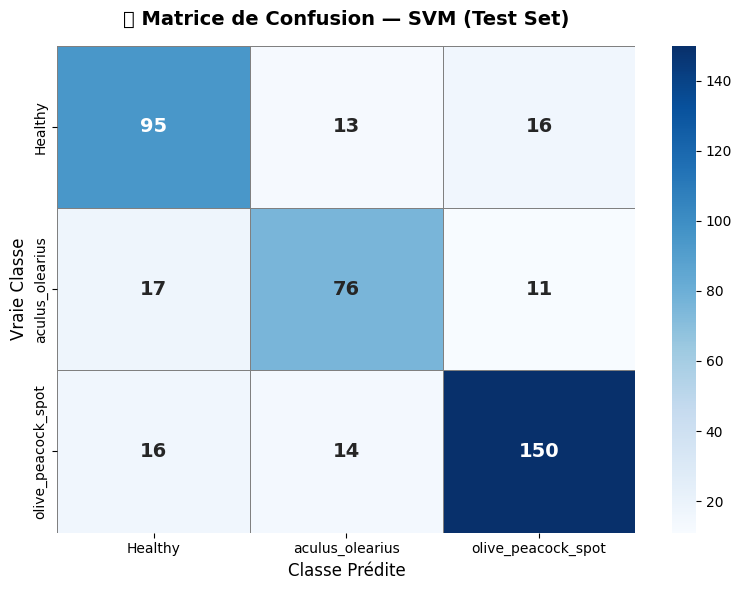

✅ Sauvegardé → reports/svm_confusion_matrix.png


In [10]:
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# MATRICE DE CONFUSION
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    linewidths=0.5, linecolor="gray",
    annot_kws={"size": 14, "weight": "bold"}
)
ax.set_title("🔵 Matrice de Confusion — SVM (Test Set)",
             fontsize=14, fontweight="bold", pad=15)
ax.set_xlabel("Classe Prédite",  fontsize=12)
ax.set_ylabel("Vraie Classe",    fontsize=12)
plt.tight_layout()
plt.savefig("reports/svm_confusion_matrix.png", dpi=150, bbox_inches="tight")
plt.show()
print("✅ Sauvegardé → reports/svm_confusion_matrix.png")

---
## 🖼️ Section 7 — Visualisation des prédictions

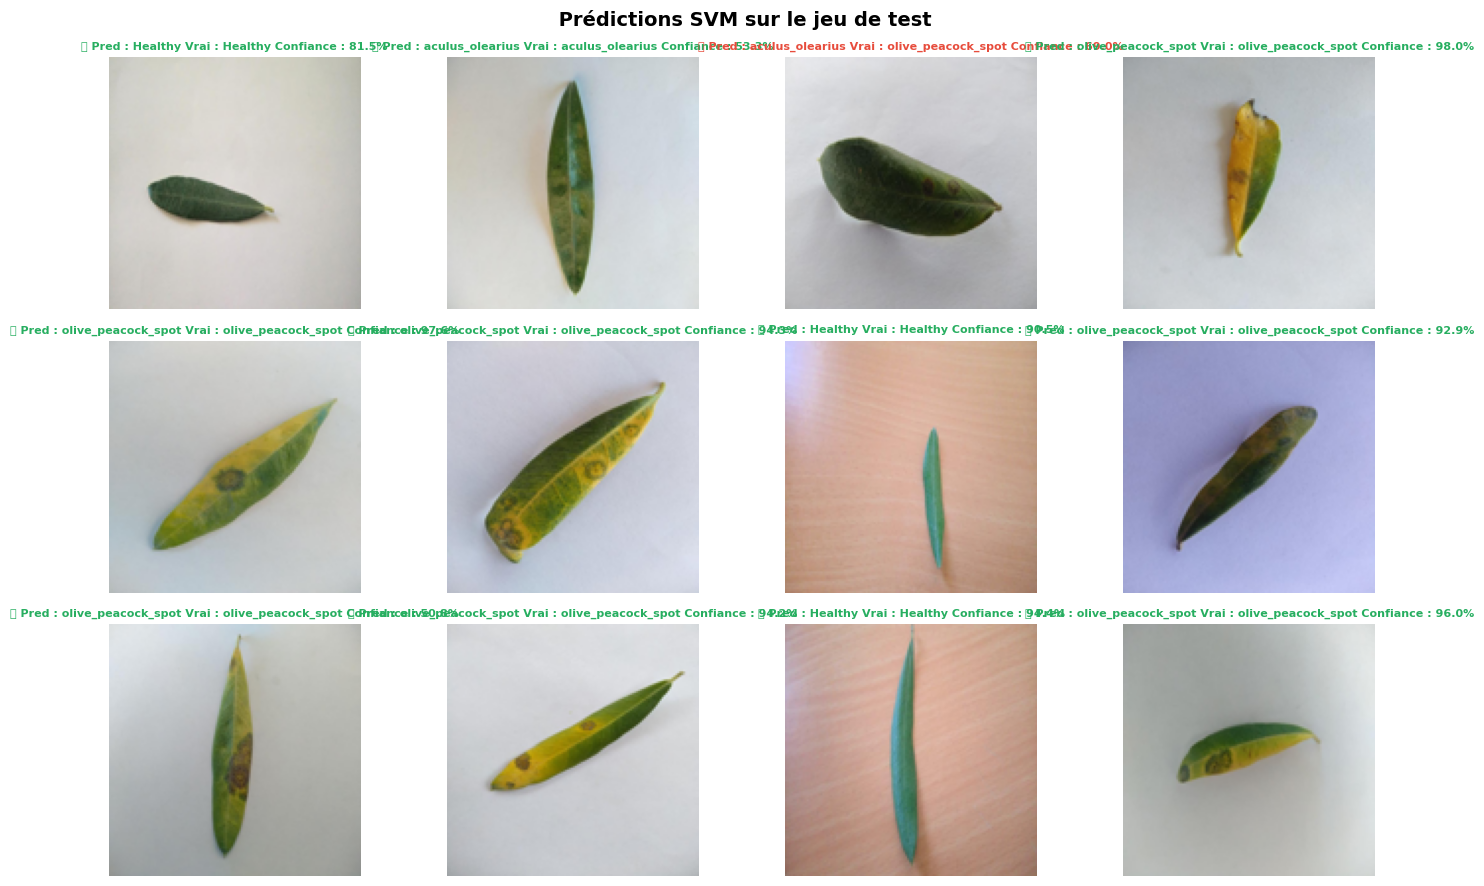

✅ Sauvegardé → reports/svm_predictions.png


In [14]:
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# AFFICHAGE DE 12 IMAGES TEST AVEC PRÉDICTION
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# Récupérer les chemins des images test
all_paths, all_labels = [], []
for cls in classes:
    cls_path = os.path.join(DATASET_PATH, cls)
    imgs = [f for f in os.listdir(cls_path)
            if f.lower().endswith((".jpg",".jpeg",".png"))]
    for img_name in imgs:
        all_paths.append(os.path.join(cls_path, img_name))
        all_labels.append(cls)

all_paths  = np.array(all_paths)
all_labels = np.array(all_labels)

# Indices du jeu de test (même seed que le split)
_, idx_temp = train_test_split(np.arange(len(all_paths)),
                               test_size=0.30, random_state=42,
                               stratify=le.transform(all_labels))
idx_val, idx_test = train_test_split(idx_temp, test_size=0.50,
                                     random_state=42,
                                     stratify=le.transform(all_labels[idx_temp]))

test_paths  = all_paths[idx_test]
test_labels = all_labels[idx_test]

# Prédictions avec scores de confiance
y_proba = pipeline.predict_proba(X_test)

fig, axes = plt.subplots(3, 4, figsize=(14, 9))
axes = axes.flatten()

for i in range(12):
    img = Image.open(test_paths[i]).convert("RGB").resize((128, 128))
    pred_idx   = y_pred[i]
    true_idx   = y_test[i]
    pred_name  = le.classes_[pred_idx]
    true_name  = le.classes_[true_idx]
    confidence = y_proba[i][pred_idx] * 100
    correct    = pred_idx == true_idx

    axes[i].imshow(img)
    axes[i].axis("off")
    icon  = "✅" if correct else "❌"
    color = "#27ae60" if correct else "#e74c3c"
    axes[i].set_title(  f"{icon} Pred : {pred_name} Vrai : {true_name} Confiance : {confidence:.1f}%",fontsize=8, color=color, fontweight="bold" )

plt.suptitle(" Prédictions SVM sur le jeu de test",  fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig("reports/svm_predictions.png", dpi=150, bbox_inches="tight")
plt.show()
print("✅ Sauvegardé → reports/svm_predictions.png")

---
## 💾 Section 8 — Sauvegarde du modèle

In [17]:
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# SAUVEGARDE
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
joblib.dump(pipeline, "models/svm_olive_pipeline.pkl")
joblib.dump(le,       "models/label_encoder.pkl")

print("✅ Pipeline SVM sauvegardé   → models/svm_olive_pipeline.pkl")
print("✅ LabelEncoder sauvegardé   → models/label_encoder.pkl")

print("" + "="*50)
print("📊 RÉSUMÉ FINAL — SVM")
print("="*50)
print(f"  Algorithme       : SVM (kernel RBF, C=10)")
print(f"  Features         : Pixels + Histogramme RGB")
print(f"  Taille image     : {IMG_SIZE}")
print(f"  Train/Val/Test   : 70% / 15% / 15%")
print(f"  Test Accuracy    : {test_acc*100:.2f}%")
print(f"  Modèle sauvegardé: models/svm_olive_pipeline.pkl")
print("="*50)
print(" Pipeline SVM complet terminé avec succès !")

✅ Pipeline SVM sauvegardé   → models/svm_olive_pipeline.pkl
✅ LabelEncoder sauvegardé   → models/label_encoder.pkl
📊 RÉSUMÉ FINAL — SVM
  Algorithme       : SVM (kernel RBF, C=10)
  Features         : Pixels + Histogramme RGB
  Taille image     : (64, 64)
  Train/Val/Test   : 70% / 15% / 15%
  Test Accuracy    : 78.68%
  Modèle sauvegardé: models/svm_olive_pipeline.pkl
 Pipeline SVM complet terminé avec succès !


---
---
# Partie 2 : Random Forest
## Objectif : Battre le SVM (78.68%)
---
On reutilise directement X_train, X_val, X_test deja calcules dans la partie SVM.

---
## Section 9 - Import Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier
print('RandomForestClassifier importe')

RandomForestClassifier importe


---
## Section 10 - Entrainement du Random Forest

In [29]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

print('Entrainement en cours... (1-3 min)')
rf.fit(X_train, y_train)

val_acc_rf = rf.score(X_val, y_val)
print('Termine !')
print(f'Validation Accuracy SVM : {pipeline.score(X_val, y_val)*100:.2f}%')

Entrainement en cours... (1-3 min)
Termine !
Validation Accuracy SVM : 80.39%


---
## Section 11 - Evaluation sur le jeu de test

In [30]:
y_pred_rf   = rf.predict(X_test)
test_acc_rf = accuracy_score(y_test, y_pred_rf)

print('=' * 55)
print('RESULTATS RANDOM FOREST -- JEU DE TEST')
print('=' * 55)
print(f'   Accuracy RF  : {test_acc_rf*100:.2f}%')
print(f'   Accuracy SVM : 78.68%')
diff  = test_acc_rf*100 - 78.68
signe = '+' if diff >= 0 else ''
print(f'   Gain         : {signe}{diff:.2f}%')
print('=' * 55)
print()
print('Rapport de classification :')
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

RESULTATS RANDOM FOREST -- JEU DE TEST
   Accuracy RF  : 75.49%
   Accuracy SVM : 78.68%
   Gain         : -3.19%

Rapport de classification :
                    precision    recall  f1-score   support

           Healthy       0.79      0.69      0.74       124
   aculus_olearius       0.70      0.63      0.67       104
olive_peacock_spot       0.76      0.87      0.81       180

          accuracy                           0.75       408
         macro avg       0.75      0.73      0.74       408
      weighted avg       0.76      0.75      0.75       408



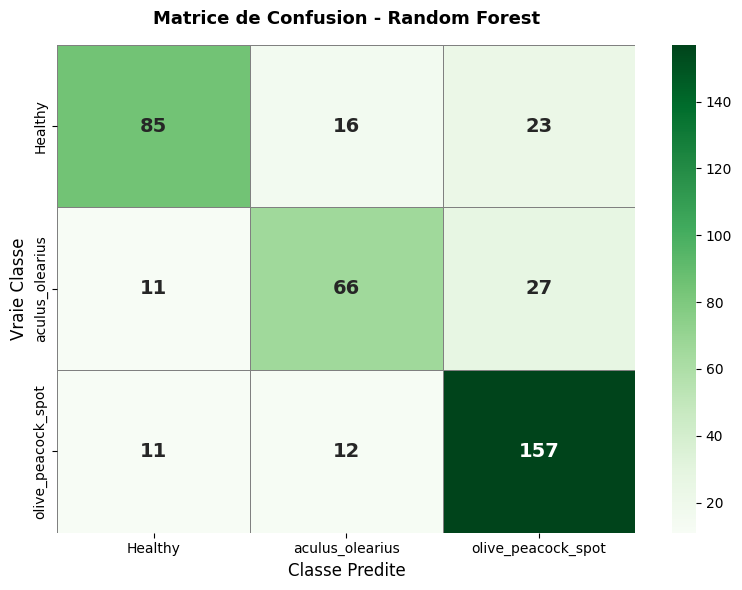

Sauvegarde -> reports/rf_confusion_matrix.png


In [31]:
cm_rf = confusion_matrix(y_test, y_pred_rf)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    cm_rf, annot=True, fmt='d', cmap='Greens',
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    linewidths=0.5, linecolor='gray',
    annot_kws={'size': 14, 'weight': 'bold'}
)
ax.set_title('Matrice de Confusion - Random Forest', fontsize=13, fontweight='bold', pad=15)
ax.set_xlabel('Classe Predite', fontsize=12)
ax.set_ylabel('Vraie Classe',   fontsize=12)
plt.tight_layout()
plt.savefig('reports/rf_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()
print('Sauvegarde -> reports/rf_confusion_matrix.png')

---
## Section 12 - Comparaison SVM vs Random Forest

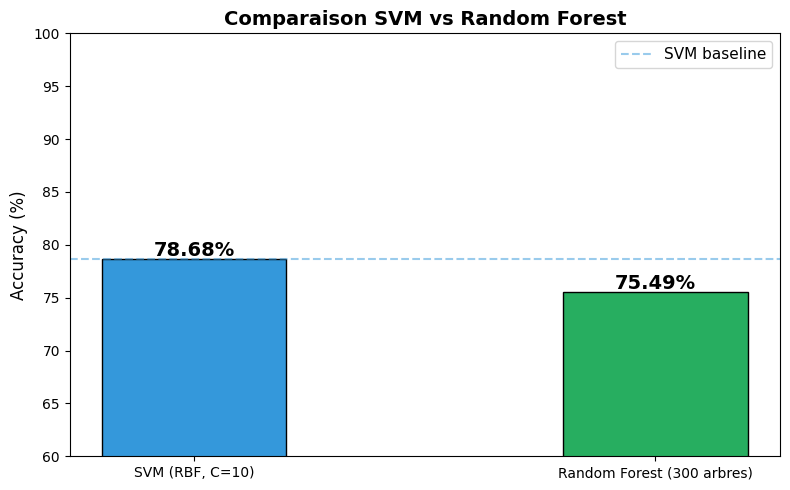

Sauvegarde -> reports/comparaison_svm_rf.png


In [32]:
algos  = ['SVM (RBF, C=10)', 'Random Forest (300 arbres)']
scores = [78.68, test_acc_rf * 100]
colors = ['#3498db', '#27ae60']

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(algos, scores, color=colors, edgecolor='black', width=0.4)

for bar, score in zip(bars, scores):
    ax.text(bar.get_x() + bar.get_width()/2,
            bar.get_height() + 0.3,
            f'{score:.2f}%',
            ha='center', fontsize=14, fontweight='bold')

ax.set_ylim(60, 100)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Comparaison SVM vs Random Forest', fontsize=14, fontweight='bold')
ax.axhline(y=78.68, color='#3498db', linestyle='--', alpha=0.5, label='SVM baseline')
ax.legend(fontsize=11)
plt.tight_layout()
plt.savefig('reports/comparaison_svm_rf.png', dpi=150, bbox_inches='tight')
plt.show()
print('Sauvegarde -> reports/comparaison_svm_rf.png')

---
## Section 13 - Importance des features

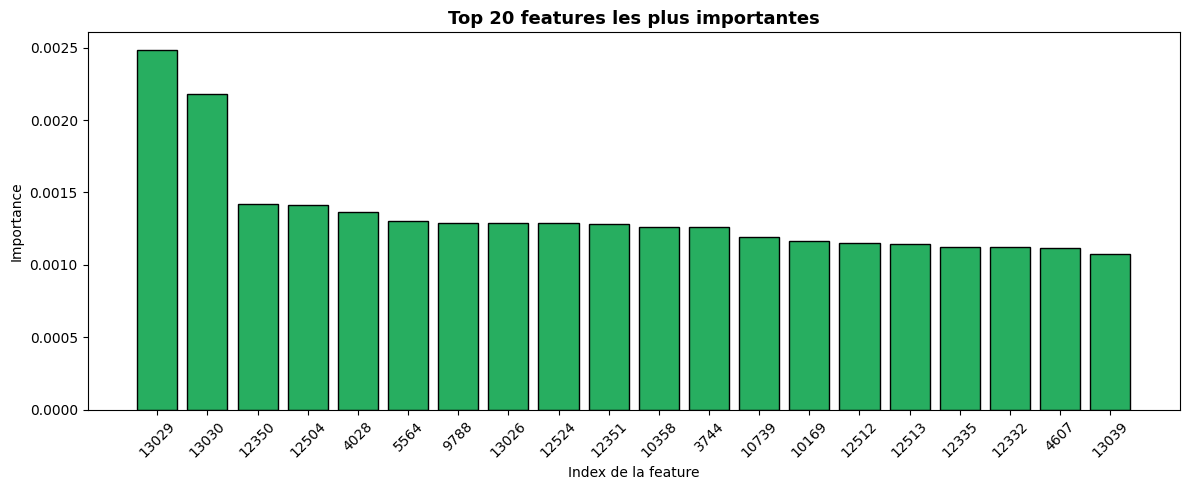

Sauvegarde -> reports/rf_feature_importance.png


In [33]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1][:20]

fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(range(20), importances[indices], color='#27ae60', edgecolor='black')
ax.set_title('Top 20 features les plus importantes', fontsize=13, fontweight='bold')
ax.set_xlabel('Index de la feature')
ax.set_ylabel('Importance')
ax.set_xticks(range(20))
ax.set_xticklabels([str(indices[i]) for i in range(20)], rotation=45)
plt.tight_layout()
plt.savefig('reports/rf_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()
print('Sauvegarde -> reports/rf_feature_importance.png')

---
## Section 14 - Sauvegarde du modele Random Forest

In [35]:
joblib.dump(rf, 'models/random_forest_olive.pkl')
print('Modele sauvegarde -> models/random_forest_olive.pkl')

print()
print('=' * 55)
print('RESUME FINAL')
print('=' * 55)
print(f'  SVM (RBF C=10)            : 78.68%')
print(f'  Random Forest (300 arbres) : {test_acc_rf*100:.2f}%')
diff  = test_acc_rf*100 - 78.68
signe = '+' if diff >= 0 else ''
print(f'  Gain RF vs SVM            : {signe}{diff:.2f}%')
print('=' * 55)
print('Pipeline complet termine !')

Modele sauvegarde -> models/random_forest_olive.pkl

RESUME FINAL
  SVM (RBF C=10)            : 78.68%
  Random Forest (300 arbres) : 75.49%
  Gain RF vs SVM            : -3.19%
Pipeline complet termine !
